In [6]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.1 MB/s eta 0:00:00


In [1]:
!pip install --no-build-isolation "earth2grid @ git+https://github.com/NVlabs/earth2grid@661445e2c68edc76f52632aa0528af482357f1b8"
!pip install earth2studio[dlesym]

  Cloning https://github.com/NVlabs/earth2grid (to revision 661445e2c68edc76f52632aa0528af482357f1b8) to /tmp/pip-install-ifs1iqkp/earth2grid_16b16a66b0684fa9bfba960457a6a063
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/earth2grid /tmp/pip-install-ifs1iqkp/earth2grid_16b16a66b0684fa9bfba960457a6a063
  Running command git rev-parse -q --verify 'sha^661445e2c68edc76f52632aa0528af482357f1b8'
  Running command git fetch -q https://github.com/NVlabs/earth2grid 661445e2c68edc76f52632aa0528af482357f1b8
  Resolved https://github.com/NVlabs/earth2grid to commit 661445e2c68edc76f52632aa0528af482357f1b8
  Preparing metadata (pyproject.toml) ... done
  Created wheel for earth2grid: filename=earth2grid-2025.7.1+torch28-cp312-cp312-linux_x86_64.whl size=7471346 sha256=e838b0f04ef279a575b83def1d410b7184e9cb36b631fb7db327045ff917e8b9
  Stored in directory: /root/.cache/pip/wheels/52/05/a6/df082c45eefb23aefe2eccc9c890a845781ffd4d94b19385aa
Successfully built earth2gr

In [1]:
import os

os.makedirs("outputs", exist_ok=True)
from dotenv import load_dotenv

load_dotenv()  # TODO: make common example prep function
import numpy as np
import torch

from earth2studio.data import ARCO
from earth2studio.data.utils import fetch_data
from earth2studio.models.px.dlesym import DLESyM, DLESyMLatLon

device = "cuda"
if not torch.cuda.is_available():
    raise RuntimeError("GPU/CUDA required for DLESyM")

# Create the data source
data = ARCO()

# Load the default model package which downloads the check point from NGC
# We will instantiate both versions of the model to demonstrate usage of each.
package = DLESyMLatLon.load_default_package()
model_ll = DLESyMLatLon.load_model(package).to(device)
package = DLESyM.load_default_package()
model_hpx = DLESyM.load_model(package).to(device)

in_coords_ll = model_ll.input_coords()
in_coords_hpx = model_hpx.input_coords()
print(
    "DLESyM LatLon input coord shapes: ",
    [(k, v.shape) for k, v in in_coords_ll.items()],
)
print(
    "DLESyM HPX input coord shapes: ", [(k, v.shape) for k, v in in_coords_hpx.items()]
)
print("Lat-lon input variable names: ", in_coords_ll["variable"])
print(
    "Lat-lon output variable names: ", model_ll.output_coords(in_coords_ll)["variable"]
)
print("HEALPix input variable names: ", in_coords_hpx["variable"])
print(
    "HEALPix output variable names: ",
    model_hpx.output_coords(in_coords_hpx)["variable"],
)

2025-10-02 19:59:49.584 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs to local cache
2025-10-02 19:59:51.026 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata to local cache
2025-10-02 19:59:51.029 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup to local cache
2025-10-02 19:59:52.775 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/level/0 to local cache


DLESyM LatLon input coord shapes:  [('batch', (0,)), ('time', (0,)), ('lead_time', (9,)), ('variable', (11,)), ('lat', (721,)), ('lon', (1440,))]
DLESyM HPX input coord shapes:  [('batch', (0,)), ('time', (0,)), ('lead_time', (9,)), ('variable', (9,)), ('face', (12,)), ('height', (64,)), ('width', (64,))]
Lat-lon input variable names:  ['z500' 'z1000' 't2m' 'tcwv' 't850' 'z250' 'sst' 'u10m' 'v10m' 'z300'
 'z700']
Lat-lon output variable names:  ['z500' 'tau300-700' 'z1000' 't2m' 'tcwv' 't850' 'z250' 'ws10m' 'sst']
HEALPix input variable names:  ['z500' 'tau300-700' 'z1000' 't2m' 'tcwv' 't850' 'z250' 'ws10m' 'sst']
HEALPix output variable names:  ['z500' 'tau300-700' 'z1000' 't2m' 'tcwv' 't850' 'z250' 'ws10m' 'sst']


In [2]:
ic_date = np.datetime64("2021-06-15")

# Fetch some example data
x, coords = fetch_data(
    source=data,
    time=np.array([ic_date]),
    variable=np.array(in_coords_ll["variable"]),
    lead_time=in_coords_ll["lead_time"],
    device=device,
)

# Can call the `DLESyMLatLon` model directly with the input lat/lon data
y, y_coords = model_ll(x, coords)

# Or, we can use the pre-processing and regridding utilities to regrid the data onto
# the HEALPix grid, and then run directly with `DLESyM`, which expects HEALPix data
x_prep, coords_prep = model_ll._prepare_derived_variables(x, coords)
x_hpx, coords_hpx = model_ll.to_hpx(x_prep), model_ll.coords_to_hpx(coords_prep)
y_hpx, y_coords_hpx = model_hpx(x_hpx, coords_hpx)

# Retrieve the valid outputs for atmos/ocean components from the predictions
y_atmos, y_atmos_coords = model_ll.retrieve_valid_atmos_outputs(y, y_coords)
y_ocean, y_ocean_coords = model_ll.retrieve_valid_ocean_outputs(y, y_coords)

print(
    "Atmosphere outputs (variables, lead_time [hrs]):",
    y_atmos_coords["variable"],
    y_atmos_coords["lead_time"].astype("timedelta64[h]"),
)
print(
    "Ocean outputs (variables, lead_time [hrs]):",
    y_ocean_coords["variable"],
    y_ocean_coords["lead_time"].astype("timedelta64[h]"),
)

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:36.522 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T00:00:00
2025-10-02 20:02:36.525 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-13T00:00:00
2025-10-02 20:02:36.527 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T00:00:00
2025-10-02 20:02:36.529 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-13T00:00:00
2025-10-02 20:02:36.532 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T00:00:00
2025-10-02 20:02:36.534 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-13T00:00:00
2025-10-02 20:02:36.537 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z700 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:36.793 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind/1064592.0.0 to local cache
2025-10-02 20:02:36.796 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064592.0.0.0 to local cache
2025-10-02 20:02:36.799 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064592.0.0.0 to local cache
2025-10-02 20:02:36.801 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind/1064592.0.0 to local cache
2025-10-02 20:02:36.806 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1

Fetching ARCO data:   0%|          | 0/11 [00:01<?, ?it/s]

2025-10-02 20:02:37.762 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064592.0.0 to local cache
2025-10-02 20:02:37.770 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064592.0.0.0 to local cache
2025-10-02 20:02:37.773 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/1064592.0.0 to local cache
2025-10-02 20:02:37.781 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/sea_surface_temperature/1064592.0.0 to local cache
2025-10-02 20:02:37.789 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:44.899 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T06:00:00
2025-10-02 20:02:44.901 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T06:00:00
2025-10-02 20:02:44.903 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-13T06:00:00
2025-10-02 20:02:44.905 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T06:00:00
2025-10-02 20:02:44.907 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T06:00:00
2025-10-02 20:02:44.910 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-13T06:00:00
2025-10-02 20:02:44.912 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:45.124 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064598.0.0 to local cache
2025-10-02 20:02:45.133 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064598.0.0.0 to local cache
2025-10-02 20:02:45.139 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/1064598.0.0 to local cache
2025-10-02 20:02:45.141 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064598.0.0.0 to local cache
2025-10-02 20:02:45.143 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/1064598.0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:52.874 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T12:00:00
2025-10-02 20:02:52.876 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T12:00:00
2025-10-02 20:02:52.878 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-13T12:00:00
2025-10-02 20:02:52.880 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T12:00:00
2025-10-02 20:02:52.882 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-13T12:00:00
2025-10-02 20:02:52.884 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T12:00:00
2025-10-02 20:02:52.886 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:02:53.107 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind/1064604.0.0 to local cache
2025-10-02 20:02:53.110 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064604.0.0 to local cache
2025-10-02 20:02:53.113 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind/1064604.0.0 to local cache
2025-10-02 20:02:53.116 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064604.0.0.0 to local cache
2025-10-02 20:02:53.118 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:00.971 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T18:00:00
2025-10-02 20:03:00.974 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T18:00:00
2025-10-02 20:03:00.976 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T18:00:00
2025-10-02 20:03:00.978 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-13T18:00:00
2025-10-02 20:03:00.980 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-13T18:00:00
2025-10-02 20:03:00.982 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T18:00:00
2025-10-02 20:03:00.984 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:01.194 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/1064610.0.0.0 to local cache
2025-10-02 20:03:01.206 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/1064610.0.0 to local cache
2025-10-02 20:03:01.209 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064610.0.0.0 to local cache
2025-10-02 20:03:01.211 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind/1064610.0.0 to local cache
2025-10-02 20:03:01.214 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:09.254 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T00:00:00
2025-10-02 20:03:09.256 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-14T00:00:00
2025-10-02 20:03:09.258 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-14T00:00:00
2025-10-02 20:03:09.261 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T00:00:00
2025-10-02 20:03:09.263 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-14T00:00:00
2025-10-02 20:03:09.265 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-14T00:00:00
2025-10-02 20:03:09.267 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:09.482 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind/1064616.0.0 to local cache
2025-10-02 20:03:09.490 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064616.0.0.0 to local cache
2025-10-02 20:03:09.493 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064616.0.0.0 to local cache
2025-10-02 20:03:09.496 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064616.0.0.0 to local cache
2025-10-02 20:03:09.498 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064616.

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:17.158 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T06:00:00
2025-10-02 20:03:17.161 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T06:00:00
2025-10-02 20:03:17.163 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-14T06:00:00
2025-10-02 20:03:17.165 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-14T06:00:00
2025-10-02 20:03:17.167 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-14T06:00:00
2025-10-02 20:03:17.169 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-14T06:00:00
2025-10-02 20:03:17.171 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:17.386 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064622.0.0 to local cache
2025-10-02 20:03:17.390 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/1064622.0.0 to local cache
2025-10-02 20:03:17.393 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064622.0.0.0 to local cache
2025-10-02 20:03:17.398 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064622.0.0.0 to local cache
2025-10-02 20:03:17.401 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/1064622.0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:25.424 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T12:00:00
2025-10-02 20:03:25.427 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-14T12:00:00
2025-10-02 20:03:25.430 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-14T12:00:00
2025-10-02 20:03:25.433 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-14T12:00:00
2025-10-02 20:03:25.436 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-14T12:00:00
2025-10-02 20:03:25.438 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T12:00:00
2025-10-02 20:03:25.441 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:25.664 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/sea_surface_temperature/1064628.0.0 to local cache
2025-10-02 20:03:25.668 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064628.0.0.0 to local cache
2025-10-02 20:03:25.671 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064628.0.0.0 to local cache
2025-10-02 20:03:25.674 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064628.0.0.0 to local cache
2025-10-02 20:03:25.677 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapo

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:33.141 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T18:00:00
2025-10-02 20:03:33.143 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-14T18:00:00
2025-10-02 20:03:33.146 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-14T18:00:00
2025-10-02 20:03:33.148 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-14T18:00:00
2025-10-02 20:03:33.151 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T18:00:00
2025-10-02 20:03:33.153 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-14T18:00:00
2025-10-02 20:03:33.156 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:33.372 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/1064634.0.0.0 to local cache
2025-10-02 20:03:33.376 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/1064634.0.0 to local cache
2025-10-02 20:03:33.379 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064634.0.0.0 to local cache
2025-10-02 20:03:33.382 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/sea_surface_temperature/1064634.0.0 to local cache
2025-10-02 20:03:33.384 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:41.150 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-15T00:00:00
2025-10-02 20:03:41.152 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-15T00:00:00
2025-10-02 20:03:41.155 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-15T00:00:00
2025-10-02 20:03:41.157 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-15T00:00:00
2025-10-02 20:03:41.159 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-15T00:00:00
2025-10-02 20:03:41.162 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-15T00:00:00
2025-10-02 20:03:41.164 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:03:41.382 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind/1064640.0.0 to local cache
2025-10-02 20:03:41.391 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064640.0.0.0 to local cache
2025-10-02 20:03:41.394 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064640.0.0.0 to local cache
2025-10-02 20:03:41.397 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/1064640.0.0.0 to local cache
2025-10-02 20:03:41.400 | DEBUG    | earth2studio.data.utils:_make_local_details:626 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/2m_temperature/1064640.

Fetching ARCO data: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Atmosphere outputs (variables, lead_time [hrs]): ['z500' 'tau300-700' 'z1000' 't2m' 'tcwv' 't850' 'z250' 'ws10m'] [ 6 12 18 24 30 36 42 48 54 60 66 72 78 84 90 96]
Ocean outputs (variables, lead_time [hrs]): ['sst'] [48 96]


In [3]:
n_steps = 16
model_iter_ll = model_ll.create_iterator(x, coords)

for i in range(n_steps):
    x, x_coords = next(model_iter_ll)
    if i > 0:  # Don't retrieve the first step as it is the initial condition
        x_atmos, x_atmos_coords = model_ll.retrieve_valid_atmos_outputs(x, x_coords)
        x_ocean, x_ocean_coords = model_ll.retrieve_valid_ocean_outputs(x, x_coords)

print(f"Completed forecast with {n_steps} steps")

Completed forecast with 16 steps


In [4]:
import earth2studio.run as run
from earth2studio.io import KVBackend

io = KVBackend()

output_coords = model_ll.output_coords(coords)
inp_lead_time = model_ll.input_coords()["lead_time"]
out_lead_times = [
    output_coords["lead_time"] + output_coords["lead_time"][-1] * i
    for i in range(n_steps)
]
output_coords["lead_time"] = np.concatenate([inp_lead_time, *out_lead_times])
io = run.deterministic(
    [ic_date], n_steps, model_ll, data, io, output_coords=output_coords
)

ds = io.to_xarray()
print(ds)

2025-10-02 20:10:09.367 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-10-02 20:10:09.367 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda


Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:09.375 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z700 at 2021-06-13T00:00:00
2025-10-02 20:10:09.377 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T00:00:00
2025-10-02 20:10:09.380 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T00:00:00
2025-10-02 20:10:09.383 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-13T00:00:00
2025-10-02 20:10:09.386 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-13T00:00:00
2025-10-02 20:10:09.389 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T00:00:00
2025-10-02 20:10:09.392 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:09.960 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T06:00:00
2025-10-02 20:10:09.962 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-13T06:00:00
2025-10-02 20:10:09.965 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-13T06:00:00
2025-10-02 20:10:09.967 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-13T06:00:00
2025-10-02 20:10:09.969 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-13T06:00:00
2025-10-02 20:10:09.971 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-13T06:00:00
2025-10-02 20:10:09.973 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:10.539 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T12:00:00
2025-10-02 20:10:10.542 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T12:00:00
2025-10-02 20:10:10.544 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-13T12:00:00
2025-10-02 20:10:10.546 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-13T12:00:00
2025-10-02 20:10:10.548 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-13T12:00:00
2025-10-02 20:10:10.550 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-13T12:00:00
2025-10-02 20:10:10.552 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:11.121 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-13T18:00:00
2025-10-02 20:10:11.124 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-13T18:00:00
2025-10-02 20:10:11.126 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-13T18:00:00
2025-10-02 20:10:11.128 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-13T18:00:00
2025-10-02 20:10:11.130 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-13T18:00:00
2025-10-02 20:10:11.132 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-13T18:00:00
2025-10-02 20:10:11.134 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:11.704 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T00:00:00
2025-10-02 20:10:11.707 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-14T00:00:00
2025-10-02 20:10:11.709 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-14T00:00:00
2025-10-02 20:10:11.711 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-14T00:00:00
2025-10-02 20:10:11.713 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-14T00:00:00
2025-10-02 20:10:11.716 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-14T00:00:00
2025-10-02 20:10:11.718 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-0

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:12.297 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T06:00:00
2025-10-02 20:10:12.300 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T06:00:00
2025-10-02 20:10:12.303 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-14T06:00:00
2025-10-02 20:10:12.305 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-14T06:00:00
2025-10-02 20:10:12.307 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-06-14T06:00:00
2025-10-02 20:10:12.310 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-14T06:00:00
2025-10-02 20:10:12.312 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:12.890 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T12:00:00
2025-10-02 20:10:12.892 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-14T12:00:00
2025-10-02 20:10:12.894 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-14T12:00:00
2025-10-02 20:10:12.896 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-14T12:00:00
2025-10-02 20:10:12.898 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z250 at 2021-06-14T12:00:00
2025-10-02 20:10:12.900 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-14T12:00:00
2025-10-02 20:10:12.902 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:13.466 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-14T18:00:00
2025-10-02 20:10:13.468 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-14T18:00:00
2025-10-02 20:10:13.470 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-14T18:00:00
2025-10-02 20:10:13.472 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-14T18:00:00
2025-10-02 20:10:13.475 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: v10m at 2021-06-14T18:00:00
2025-10-02 20:10:13.477 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t2m at 2021-06-14T18:00:00
2025-10-02 20:10:13.479 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-

Fetching ARCO data:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:10:14.059 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z500 at 2021-06-15T00:00:00
2025-10-02 20:10:14.062 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: t850 at 2021-06-15T00:00:00
2025-10-02 20:10:14.064 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z300 at 2021-06-15T00:00:00
2025-10-02 20:10:14.066 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: z1000 at 2021-06-15T00:00:00
2025-10-02 20:10:14.068 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: u10m at 2021-06-15T00:00:00
2025-10-02 20:10:14.070 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: tcwv at 2021-06-15T00:00:00
2025-10-02 20:10:14.073 | DEBUG    | earth2studio.data.arco:fetch_array:288 - Fetching ARCO zarr array for variable: sst at 2021-

Fetching ARCO data: 100%|██████████| 11/11 [00:00<00:00, 19.10it/s]


2025-10-02 20:10:15.110 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from ARCO
2025-10-02 20:10:16.142 | INFO     | earth2studio.run:deterministic:136 - Inference starting!



Running inference: 100%|██████████| 17/17 [00:26<00:00,  1.55s/it]

2025-10-02 20:10:42.557 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete
<xarray.Dataset> Size: 10GB
Dimensions:     (time: 1, lead_time: 265, lat: 721, lon: 1440)
Coordinates:
  * time        (time) datetime64[s] 8B 2021-06-15
  * lead_time   (lead_time) timedelta64[ns] 2kB -2 days +00:00:00 ... 64 days...
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    z500        (time, lead_time, lat, lon) float32 1GB 5.253e+04 ... 4.718e+04
    tau300-700  (time, lead_time, lat, lon) float32 1GB 5.85e+04 ... 5.452e+04
    z1000       (time, lead_time, lat, lon) float32 1GB 890.4 890.4 ... -650.8
    t2m         (time, lead_time, lat, lon) float32 1GB 273.7 273.7 ... 214.2
    tcwv        (time, lead_time, lat, lon) float32 1GB 8.898 8.898 ... 0.5895
    t850        (time, lead_time, lat, lon) float32 1GB 265.6 265.6 ... 231.3
    z250        (time,

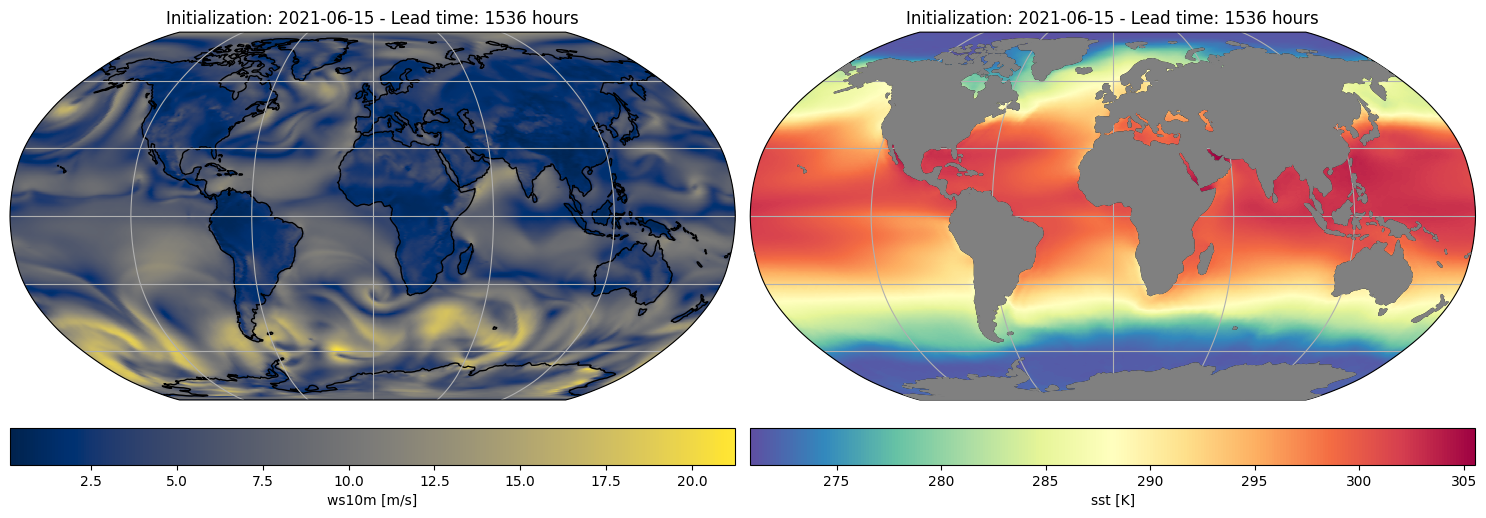

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# lat = x_atmos_coords["lat"]
# lon = x_atmos_coords["lon"]
atmos_var, atmos_units = "ws10m", "m/s"
ocean_var, ocean_units = "sst", "K"
# atmos_var_idx = list(x_atmos_coords["variable"]).index(atmos_var)
# ocean_var_idx = list(x_ocean_coords["variable"]).index(ocean_var)
lead_time = ds.lead_time.values[-1]

plt.close("all")
# Create a Robinson projection
projection = ccrs.Robinson()

# Create a figure and axes with the specified projection
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": projection}, figsize=(15, 6))

# Plot the field using pcolormesh
im = axs[0].pcolormesh(
    ds.lon.values,
    ds.lat.values,
    ds[atmos_var].sel(time=ic_date, lead_time=lead_time).values,
    transform=ccrs.PlateCarree(),
    cmap="cividis",
)

# Set title
axs[0].set_title(
    f"Initialization: {ic_date} - Lead time: {lead_time.astype('timedelta64[h]')}"
)

# Add coastlines and gridlines
axs[0].coastlines()
axs[0].gridlines()

cbar = fig.colorbar(im, ax=axs[0], orientation="horizontal", pad=0.05)
cbar.set_label(f"{atmos_var} [{atmos_units}]")

# Plot the ocean component
im = axs[1].pcolormesh(
    ds.lon.values,
    ds.lat.values,
    ds[ocean_var].sel(time=ic_date, lead_time=lead_time).values,
    transform=ccrs.PlateCarree(),
    cmap="Spectral_r",
)

axs[1].set_title(
    f"Initialization: {ic_date} - Lead time: {lead_time.astype('timedelta64[h]')}"
)

# Add coastlines and gridlines
axs[1].add_feature(cfeature.LAND, color="grey", zorder=100)
axs[1].coastlines()
axs[1].gridlines()

cbar = fig.colorbar(im, ax=axs[1], orientation="horizontal", pad=0.05)
cbar.set_label(f"{ocean_var} [{ocean_units}]")

plt.tight_layout()
plt.savefig("outputs/14_ws10m_sst_prediction.png")